# RoBERTa with Fastai

modification of https://github.com/devkosal/fastai_roberta/blob/master/fastai_roberta_imdb/Using%20RoBERTa%20with%20Fastai%20Tutorial.ipynb

tutorial at https://medium.com/@devkosal/using-roberta-with-fastai-for-nlp-7ed3fed21f6c

run on Google Cloud Platform with 8 vCPUs, 52 GB memory, 1 NVIDIA Tesla T4

In [1]:
from fastai.text import *
from fastai.metrics import *
from pytorch_transformers import RobertaTokenizer

In [2]:
# Creating a config object to store task specific information
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)
        
config = Config(
    testing=True,
    seed = 42,
    roberta_model_name='roberta-base', # can also be exchanged with roberta-large 
    max_lr=1e-5,
    epochs=1,
    use_fp16=False,
    bs=32, 
    max_seq_len=256, 
    num_labels = 2,
    hidden_dropout_prob=.05,
    hidden_size=768, # 1024 for roberta-large
    start_tok = "<s>",
    end_tok = "</s>",
)

In [3]:
df = pd.read_csv('/home/jupyter/data/IMDB Dataset.csv')

In [4]:
if config.testing: df = df[:5000]
print(df.shape)

(5000, 2)


In [5]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
feat_cols = "review"
label_cols = "sentiment"

## Setting Up the Tokenizer

In [7]:
class FastAiRobertaTokenizer(BaseTokenizer):
    """Wrapper around RobertaTokenizer to be compatible with fastai"""
    def __init__(self, tokenizer: RobertaTokenizer, max_seq_len: int=128, **kwargs): 
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len 
    def __call__(self, *args, **kwargs): 
        return self 
    def tokenizer(self, t:str) -> List[str]: 
        """Adds Roberta bos and eos tokens and limits the maximum sequence length""" 
        return [config.start_tok] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + [config.end_tok]

In [8]:
# create fastai tokenizer for roberta
roberta_tok = RobertaTokenizer.from_pretrained("roberta-base")

fastai_tokenizer = Tokenizer(tok_func=FastAiRobertaTokenizer(roberta_tok, max_seq_len=config.max_seq_len), 
                             pre_rules=[], post_rules=[])

In [9]:
# create fastai vocabulary for roberta
path = Path()
roberta_tok.save_vocabulary(path)

with open('vocab.json', 'r') as f:
    roberta_vocab_dict = json.load(f)
    
fastai_roberta_vocab = Vocab(list(roberta_vocab_dict.keys()))

In [10]:
# Setting up pre-processors
class RobertaTokenizeProcessor(TokenizeProcessor):
    def __init__(self, tokenizer):
         super().__init__(tokenizer=tokenizer, include_bos=False, include_eos=False)

class RobertaNumericalizeProcessor(NumericalizeProcessor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, vocab=fastai_roberta_vocab, **kwargs)


def get_roberta_processor(tokenizer:Tokenizer=None, vocab:Vocab=None):
    """
    Constructing preprocessors for Roberta
    We remove sos and eos tokens since we add that ourselves in the tokenizer.
    We also use a custom vocabulary to match the numericalization with the original Roberta model.
    """
    return [RobertaTokenizeProcessor(tokenizer=tokenizer), NumericalizeProcessor(vocab=vocab)]

## Setting up the DataBunch

In [11]:
# Creating a Roberta specific DataBunch class
class RobertaDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training Roberta"
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=64, val_bs:int=None, pad_idx=1,
               pad_first=True, device:torch.device=None, no_check:bool=False, backwards:bool=False, 
               dl_tfms:Optional[Collection[Callable]]=None, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(pad_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, dl_tfms=dl_tfms, collate_fn=collate_fn, no_check=no_check)

In [12]:
class RobertaTextList(TextList):
    _bunch = RobertaDataBunch
    _label_cls = TextList

In [13]:
# loading the tokenizer and vocab processors
processor = get_roberta_processor(tokenizer=fastai_tokenizer, vocab=fastai_roberta_vocab)

# creating our databunch 
data = RobertaTextList.from_df(df, ".", cols=feat_cols, processor=processor) \
    .split_by_rand_pct(seed=config.seed) \
    .label_from_df(cols=label_cols,label_cls=CategoryList) \
    .databunch(bs=config.bs, pad_first=False, pad_idx=0)

# Building the Model

In [14]:
import torch
import torch.nn as nn
from pytorch_transformers import RobertaModel

# defining our model architecture 
class CustomRobertaModel(nn.Module):
    def __init__(self,num_labels=2):
        super(CustomRobertaModel,self).__init__()
        self.num_labels = num_labels
        self.roberta = RobertaModel.from_pretrained(config.roberta_model_name)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, num_labels) # defining final output layer
        
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        _ , pooled_output = self.roberta(input_ids, token_type_ids, attention_mask) # 
        logits = self.classifier(pooled_output)        
        return logits

In [15]:
from fastai.metrics import Precision, Recall, FBeta

precision = Precision(pos_label=1)
recall = Recall(pos_label=1)
f1 = FBeta(pos_label=1, beta=1)

In [16]:
roberta_model = CustomRobertaModel(num_labels=config.num_labels)

learn = Learner(data, roberta_model, 
                metrics=[accuracy, precision, recall, f1])

In [17]:
learn.model.roberta.train() # setting roberta to train as it is in eval mode by default
learn.fit_one_cycle(config.epochs, max_lr=config.max_lr)

epoch,train_loss,valid_loss,accuracy,precision,recall,f_beta,time
0,0.338773,0.227290,0.914000,0.938356,0.874468,0.905286,02:57


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


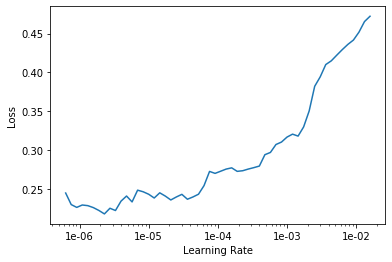

In [25]:
learn.lr_find()
learn.recorder.plot()

In [19]:
#learn.export(file='IMDB_Roberta.pkl')

### Test with random data

In [20]:
#learn = load_learner(path, file='IMDB_Roberta.pkl')

In [21]:
test_list = [
    ('The movie is good in the first part but I find very boring onwards', 'negative'),
    ('Although this is a budget movie and actors are not famous, I really enjoy watching it.', 'positive'),
    ('This movie is so sick! One of the best!', 'positive'),
]
test_df = pd.DataFrame(test_list, columns=['review', 'sentiment'])

In [22]:
predicted = [str(learn.predict(t)[0]) for t in test_df['review']]
test_df['predicted'] = predicted

In [23]:
from sklearn.metrics import classification_report

print(classification_report(test_df['sentiment'], predicted, labels=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00         1
    positive       1.00      1.00      1.00         2

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



In [24]:
test_df

,review,sentiment,predicted
0,The movie is good in the first part but I find...,negative,negative
1,Although this is a budget movie and actors are...,positive,positive
2,This movie is so sick! One of the best!,positive,positive
